In [110]:
# imports
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [66]:
# Notebook variables
SEED_VALUE = 72
TRAIN_SIZE = 0.8
TEST_SIZE = 0.2

trainDataPath = "../input/train.csv"


In [123]:
# Functions

# Plot mutual information data
def plot_mi_scores(scores, axis, title):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    axis.barh(width, scores)
    axis.set_yticks(width, ticks)
    axis.set_title(title)

# Function for comparing different approaches
def score_gradientboosting_model(X_train, X_valid, y_train, y_valid, n_estimators=200, max_depth=20):
    model = GradientBoostingClassifier(n_estimators=n_estimators, random_state=SEED_VALUE, max_depth=max_depth)
    model.fit(X_train, y_train)
    preds = model.predict(X_valid)
    return mean_absolute_error(y_valid, preds), accuracy_score(y_valid, preds)

def score_randomforest_model(X_train, X_valid, y_train, y_valid, n_estimators=200, max_depth=20):
    model = RandomForestClassifier(n_estimators=n_estimators, random_state=SEED_VALUE, max_depth=max_depth)
    model.fit(X_train, y_train)
    preds = model.predict(X_valid)
    return mean_absolute_error(y_valid, preds), accuracy_score(y_valid, preds)

def create_fare_bins(data):
    binData = data.copy()

    binData.loc[binData["Fare"] >= 0, "f_Fare"] = 0
    binData.loc[binData["Fare"] > 25, "f_Fare"] = 1
    binData.loc[binData["Fare"] > 50, "f_Fare"] = 2
    binData.loc[binData["Fare"] > 75, "f_Fare"] = 3
    binData.loc[binData["Fare"] > 100, "f_Fare"] = 4

    return binData

def create_age_bins(data, replacementValue):
    binData = data.copy()

    binData["Age"] = binData["Age"].fillna(replacementValue)

    binData.loc[binData["Age"] >= 0, "f_Age"] = 0
    binData.loc[binData["Age"] > 10, "f_Age"] = 1
    binData.loc[binData["Age"] > 20, "f_Age"] = 2
    binData.loc[binData["Age"] > 30, "f_Age"] = 3
    binData.loc[binData["Age"] > 40, "f_Age"] = 4
    binData.loc[binData["Age"] > 50, "f_Age"] = 5
    binData.loc[binData["Age"] > 60, "f_Age"] = 6
    binData.loc[binData["Age"] > 70, "f_Age"] = 7
    binData.loc[binData["Age"] > 80, "f_Age"] = 8

    return binData

def create_sibsp_bins(data):
    binData = data.copy()

    binData.loc[binData["SibSp"] == 0, "f_SibSp"] = 0
    binData.loc[binData["SibSp"] == 1, "f_SibSp"] = 1
    binData.loc[binData["SibSp"] > 1, "f_SibSp"] = 2

    return binData

def create_parch_bins(data):
    binData = data.copy()

    binData.loc[binData["Parch"] == 0, "f_ParCh"] = 0
    binData.loc[binData["Parch"] > 0, "f_ParCh"] = 1

    return binData

def create_sex_bins(data):
    binData = data.copy()

    maleTitles = ["Mr", "Master", "Don", "Rev", "Major", "Sir", "Col", "Capt"]
    femaleTitles = ["Mrs", "Miss", "Mme", "Ms", "Lady", "Mlle", "Countess"]

    binData["Title"] = binData['Name'].str.extract(' ([A-Za-z]+)\.', expand = False)

    binData.loc[binData["Sex"].isna() & binData["Title"].isin(maleTitles), "f_Sex"] = "male"
    binData.loc[binData["Sex"].isna() & binData["Title"].isin(femaleTitles), "f_Sex"] = "female"

    binData.loc[binData["Sex"] == "male", "f_Sex"] = 0
    binData.loc[binData["Sex"] == "female", "f_Sex"] = 1

    return binData

def create_cabin_code(data):
    data["f_CabinCode"] = data["Cabin"].str.extract('(^.{0,1})')
    data.loc[data["f_CabinCode"].isna(), "f_CabinCode"] = "U"

    return data

def create_cabin_bins(data):
    binData = data.copy()

    binData.loc[binData["f_CabinCode"] == "U", "f_Cabin"] = 0
    binData.loc[binData["f_CabinCode"] != "U", "f_Cabin"] = 1

    return binData


In [68]:
# Load initial data

rawData = pd.read_csv(trainDataPath, index_col="PassengerId")
rawTargetData = rawData.Survived
rawTrainData = rawData.drop(["Survived"], axis=1)

# Split up data
trainData, validationData, trainTarget, validationTarget = train_test_split(rawData, rawTargetData, train_size=TRAIN_SIZE, test_size=TEST_SIZE, random_state=SEED_VALUE)


## Pre-processing

### Fare - `f_Fare`

Looking at fare, most are between 0 and 50 and it does seem to be an indicator of survival. I break them up in to brackets of $25 up to anything over $100. This loses some information from the data but hopefully allows us to generalise better.

### Age - `f_Age`

There does seem to a bit of info here to look at so I've broken age in to bins by groups of 10. We will see if this helps us

### Sibling/Spouse - `f_SibSp`

There does seem to be some useful information here and looking at binning it by `0`, `1` and `2`. This will be records with 0, 1 or more than 1.

### Parent/Child - `f_ParCh`

There does seem to be some useful information here and looking at binning it by `0`, `1`. This will be records with 0 or more than 0.

<AxesSubplot:xlabel='f_Cabin', ylabel='Count'>

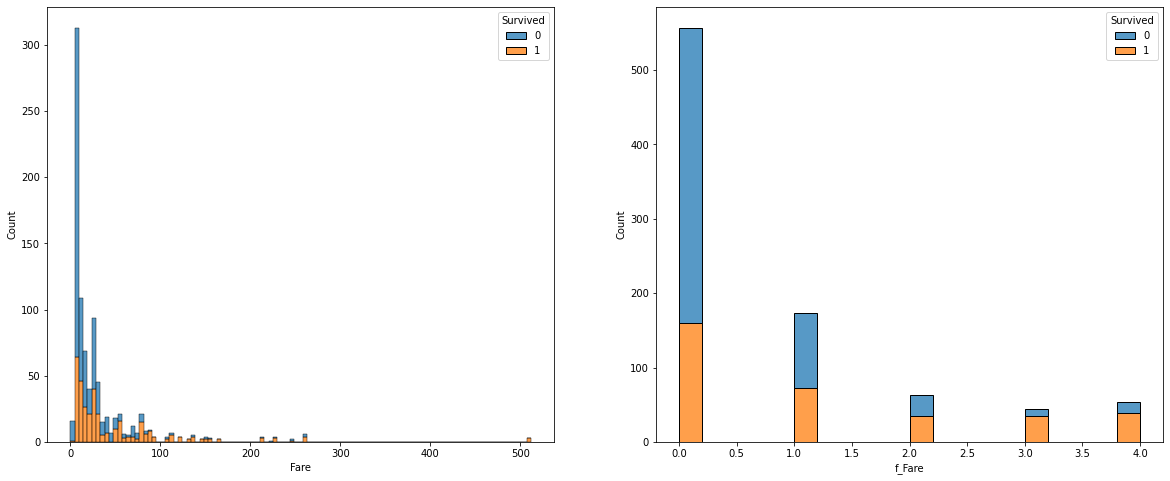

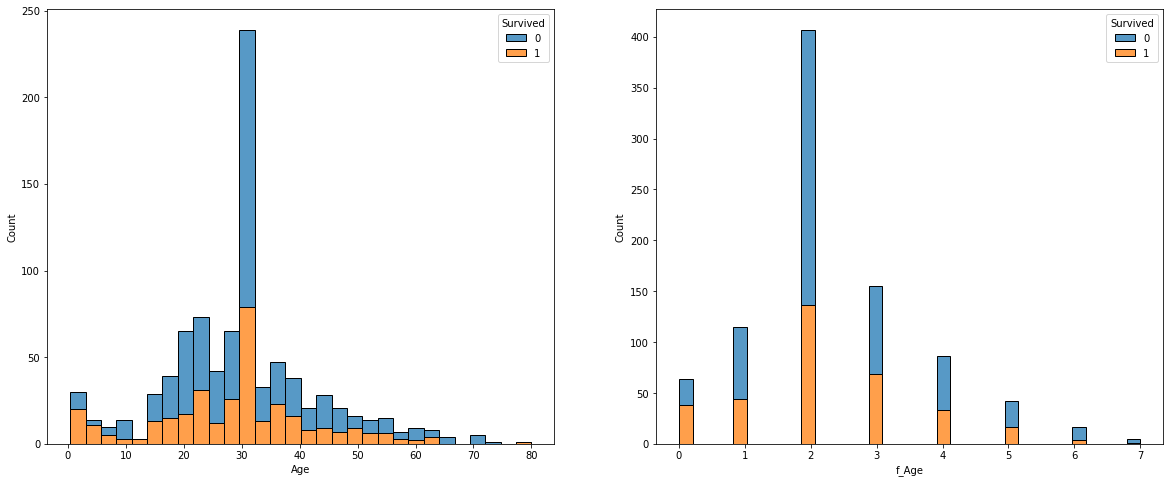

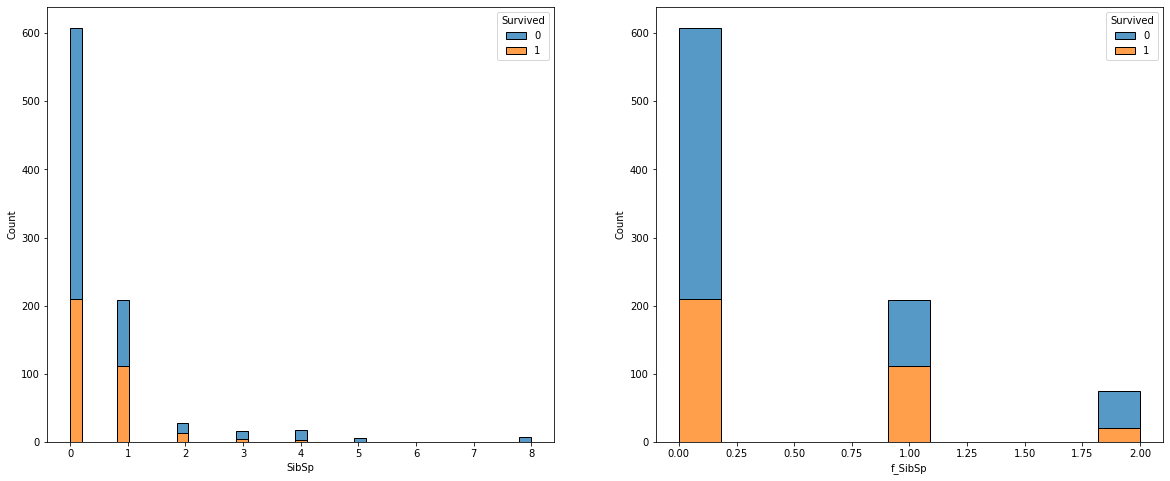

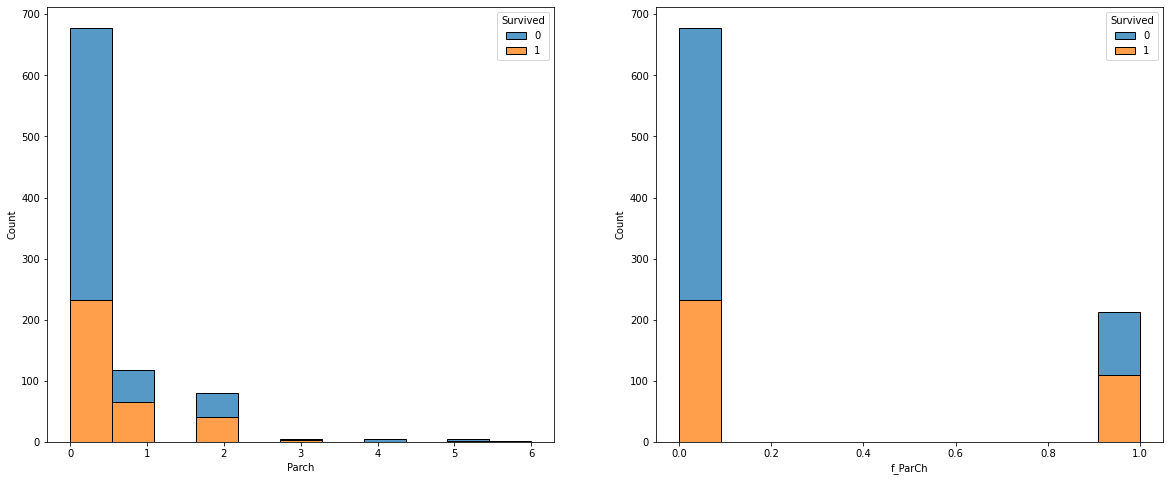

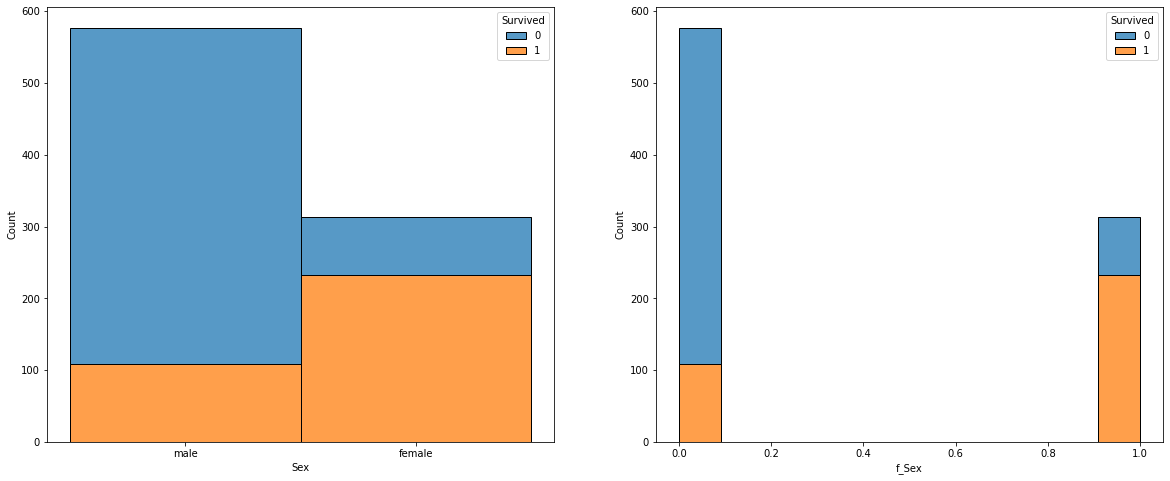

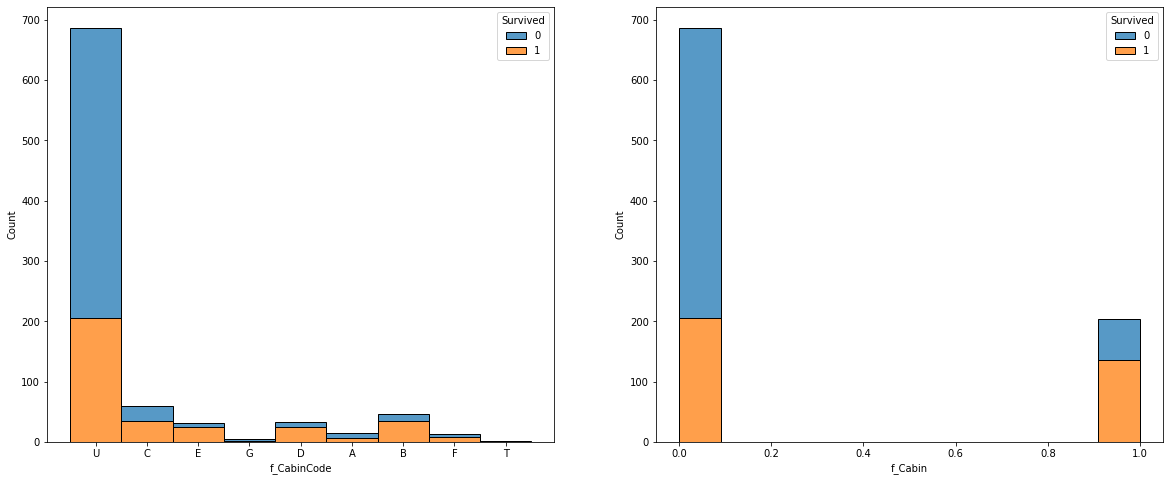

In [126]:
# Investigation

# Get values to use for missing dataa
meanAge = trainData["Age"].mean()

# Create features
ppData = create_fare_bins(rawData)
ppData = create_age_bins(ppData, meanAge)
ppData = create_sibsp_bins(ppData)
ppData = create_parch_bins(ppData)
ppData = create_sex_bins(ppData)
ppData = create_cabin_code(ppData)
ppData = create_cabin_bins(ppData)

fig, ax = plt.subplots(1, 2, figsize=(20,8))
sns.histplot(data = ppData, x = "Fare", ax=ax[0], hue = "Survived", multiple="stack")
sns.histplot(data = ppData, x = "f_Fare", ax=ax[1], hue = "Survived", multiple="stack")

# Age processing
fig, ax = plt.subplots(1, 2, figsize=(20,8))
sns.histplot(data = ppData, x = "Age", ax=ax[0], hue = "Survived", multiple="stack")
sns.histplot(data = ppData, x = "f_Age", ax=ax[1], hue = "Survived", multiple="stack")

# SibSp processing
fig, ax = plt.subplots(1, 2, figsize=(20,8))
sns.histplot(data = ppData, x = "SibSp", ax=ax[0], hue = "Survived", multiple="stack")
sns.histplot(data = ppData, x = "f_SibSp", ax=ax[1], hue = "Survived", multiple="stack")

# Parch processing
fig, ax = plt.subplots(1, 2, figsize=(20,8))
sns.histplot(data = ppData, x = "Parch", ax=ax[0], hue = "Survived", multiple="stack")
sns.histplot(data = ppData, x = "f_ParCh", ax=ax[1], hue = "Survived", multiple="stack")

# Parch processing
fig, ax = plt.subplots(1, 2, figsize=(20,8))
sns.histplot(data = ppData, x = "Sex", ax=ax[0], hue = "Survived", multiple="stack")
sns.histplot(data = ppData, x = "f_Sex", ax=ax[1], hue = "Survived", multiple="stack")

# Cabin processing
fig, ax = plt.subplots(1, 2, figsize=(20,8))
sns.histplot(data = ppData, x = "f_CabinCode", ax=ax[0], hue = "Survived", multiple="stack")
sns.histplot(data = ppData, x = "f_Cabin", ax=ax[1], hue = "Survived", multiple="stack")

## Create and test models


In [130]:
# Create and test models

# Features to use
features = ["f_Age", "f_Fare", "f_SibSp", "f_ParCh", "f_Sex", "f_Cabin"]

# Create datasets
modelTrain = create_fare_bins(trainData)
modelTrain = create_age_bins(modelTrain, meanAge)
modelTrain = create_sibsp_bins(modelTrain)
modelTrain = create_parch_bins(modelTrain)
modelTrain = create_sex_bins(modelTrain)
modelTrain = create_cabin_code(modelTrain)
modelTrain = create_cabin_bins(modelTrain)
modelTrain = modelTrain[features]

modelValidation = create_fare_bins(validationData)
modelValidation = create_age_bins(modelValidation, meanAge)
modelValidation = create_sibsp_bins(modelValidation)
modelValidation = create_parch_bins(modelValidation)
modelValidation = create_sex_bins(modelValidation)
modelValidation = create_cabin_code(modelValidation)
modelValidation = create_cabin_bins(modelValidation)
modelValidation = modelValidation[features]

scores = []

rf_mae, rf_accuracy = score_randomforest_model(modelTrain, modelValidation, trainTarget, validationTarget)
gb_mae, gb_accuracy = score_gradientboosting_model(modelTrain, modelValidation, trainTarget, validationTarget)

scores.append(
  {
    "modelType": "RandomForestClassifier",
    "mae": rf_mae,
    "accuracy": rf_accuracy
  }
)
scores.append(
  {
    "modelType": "GradientBoostingClassifier",
    "mae": gb_mae,
    "accuracy": gb_accuracy
  }
)

pd.DataFrame(scores)


,modelType,mae,accuracy
0,RandomForestClassifier,0.201117,0.798883
1,GradientBoostingClassifier,0.201117,0.798883
